---
description: Use camera intrinsics to undistort video and gaze data
---

# Use Camera Intrinsics to Undistort Video and Gaze Data
Pupil Invisible's scene camera has a very large field of view and is affected by lens distortion accordingly. Every scene camera is calibrated during manufacturing to obtain it's "intrinsic values" though, which allows us to remove the distortion if desired.

In this guide you will learn how to use the intrinsic values to apply undistortion to the scene video and gaze data. This could be done using OpenCV directly, but the camera related methods have a rather unintuitive API. Thus, we have written a small wrapper called `pupil_labs.camera` which makes things much easier!

<div class="pb-4">
  <img width="100%" height="auto" src="../../../../media/invisible/how-tos/cloud_gaze_overlay_undistorted.jpeg" alt="An example of undistortion">
</div>

### Dependencies for this How-To

In order to run the code in this How-To, you will need to install the following Python dependencies, including the camera wrapper:

```
pip install av matplotlib numpy opencv-python pandas requests tqdm pupil_labs_camera
```

We will use the `Anna_Standing_Downstairs` recording from the [demo workspace](https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9/recordings) as an example for this guide. If you want to follow along, download it and unpack it in a `data/demo_recording` folder next to this notebook.

You can download all the code of this guide [here](https://github.com/pupil-labs/pupil-docs/blob/master/src/invisible/how-tos/advanced-analysis/intrinsics/README.ipynb).

### Obtaining Camera Intrinsic Values
You can find the intrinsic values of the scene camera in the `scene_camera.json` file, which is included in every recording folder you download from Pupil Cloud. This also holds true for the demo recording! We can read the camera matrix and the distortion coefficients, which make up the camera intrinsics, as follows.

In [1]:
import json
with open("data/demo_recording/anna_standing_downstairs-b1eafeee/scene_camera.json", "r") as f:
  data = json.load(f)

camera_matrix = data["camera_matrix"]
dist_coeffs = data["dist_coefs"]

print("Camera Matrix:")
print(camera_matrix)
print("Distortion Coefficients:")
print(dist_coeffs)

Camera Matrix:
[[765.469082753157, 0.0, 567.0954541838603], [0.0, 765.2673080778297, 545.3177094076727], [0.0, 0.0, 1.0]]
Distortion Coefficients:
[[-0.12591202244566754, 0.101181790269097, 0.0006819575150849819, -0.0004815612057156913, 0.018952897627046664, 0.20535990250436098, 0.007459782333401985, 0.06701927729864841]]


### Undistorting Images and Points
With the camera matrix and distortion coefficients available, we are now able to undistort images and points. If we want to undistort the scene camera video, it is critical that we undistort the gaze data as well. The gaze data is in scene camera coordinates and if we warp the scene camera images via undistortion, the gaze would otherwise no longer be accurate.

For simplicity, we will first undistort only a single image and a few artificial example points. Afterwards, we will go through an example of undistorting and entire Pupil Invisible recording.

The original distorted data looks as follows. Note that some lines that are straight in real life appear slightly curved in the image due to the distortion. For example the rail of the lamp, or the edges of the paintings.

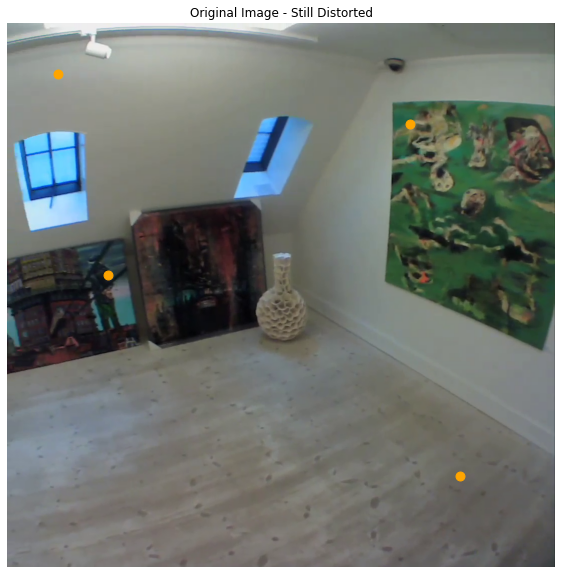

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("data/example_frame.png")

example_points = np.array(
    [
        (100.0, 100.0),
        (800.0, 200.0),
        (200.0, 500.0),
        (900.0, 900.0),
    ]
)

# Plot the original distorted version
plt.figure(figsize=(10, 10))
# Convert color space for plotting with matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.scatter(example_points[:, 0], example_points[:, 1], color="orange", s=80)
plt.title("Original Image - Still Distorted")
plt.axis("off");


We can now use the `pupil_labs.camera` module (or `plc` for short) undistort the image and example points. Note, how all straight lines appear straight in the undistorted image. Also, the image is slightly cropped, e.g. the rail of the lamp is no longer in the image and the top left example point is outside of the image now.

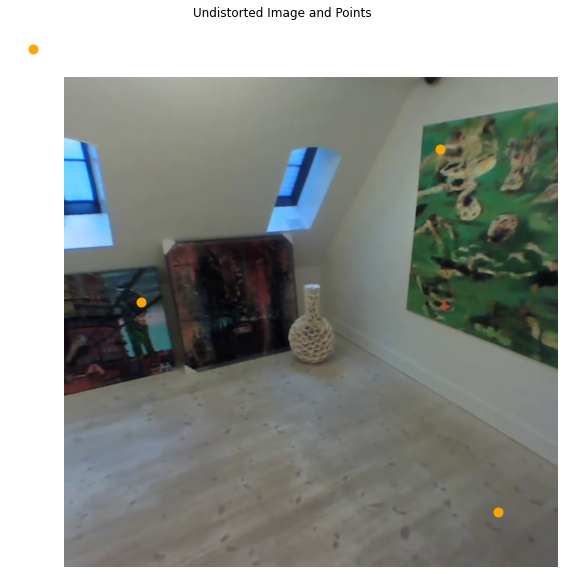

In [11]:
import pupil_labs.camera as plc
cam = plc.CameraRadial(
    pixel_width=1088, 
    pixel_height=1080, 
    camera_matrix=camera_matrix, 
    dist_coeffs=dist_coeffs,
)

img_undist = cam.undistort_image(img)
example_points_undist = cam.undistort_points_on_image_plane(example_points)

# Plot the undistorted version
plt.figure(figsize=(10, 10))
plt.imshow(img_undist)
plt.scatter(
    example_points_undist[:, 0], example_points_undist[:, 1], color="orange", s=80
)
plt.title("Undistorted Image and Points")
plt.axis("off");


### Undistort a full Recording
To undistort a full recording we simply need to apply the undistortion to every video frame and all gaze data. This requires additional code to handle the video correctly, but the undistortion works just the same.

Note, that we are using PyAV to handle the video rather than OpenCV. Handling videos with OpenCV often has issues and PyAV additionally allows us to correctly handle the audio track of the video, if there is one.

In [7]:
import pathlib

import av
from tqdm import tqdm
import pandas as pd


def undistort_video(
    original_video_path, undistorted_video_path
):
    timestamps_path = pathlib.Path(original_video_path).with_name(
        "world_timestamps.csv"
    )
    num_frames = pd.read_csv(timestamps_path).shape[0]
    original_container = av.open(str(original_video_path))
    original_video_stream = original_container.streams.video[0]

    undistorted_container = av.open(str(undistorted_video_path), "w")

    try:
        undistorted_video = undistorted_container.add_stream("h264_nvenc")
    except Exception as e:
        print("nvenc not available", e)
        undistorted_video = undistorted_container.add_stream("h264")

    undistorted_video.options["bf"] = "0"
    undistorted_video.options["movflags"] = "faststart"
    undistorted_video.gop_size = original_video_stream.gop_size
    undistorted_video.codec_context.height = original_video_stream.height
    undistorted_video.codec_context.width = original_video_stream.width
    undistorted_video.codec_context.time_base = original_video_stream.time_base
    undistorted_video.codec_context.bit_rate = original_video_stream.bit_rate

    if original_container.streams.audio:
        audio_stream = original_container.streams.audio[0]
        output_audio_stream = undistorted_container.add_stream("aac")
        output_audio_stream.codec_context.layout = audio_stream.layout.name
        output_audio_stream.codec_context.time_base = audio_stream.time_base
        output_audio_stream.codec_context.bit_rate = audio_stream.bit_rate
        output_audio_stream.codec_context.sample_rate = audio_stream.sample_rate

    progress = tqdm(unit=" frames", total=num_frames)
    with undistorted_container:
        for packet in original_container.demux():
            frames = packet.decode()

            if packet.stream.type == "audio":
                for frame in frames:
                    frame.pts = None
                    packets = output_audio_stream.encode(frame)
                    undistorted_container.mux(packets)
            elif packet.stream.type == "video":
                for frame in frames:
                    img = frame.to_ndarray(format="bgr24")
                    undistorted_img = cam.undistort_image(img)
                    new_frame = frame.from_ndarray(undistorted_img, format="bgr24")
                    new_frame.pts = frame.pts
                    new_frame.time_base = original_video_stream.time_base
                    packets = undistorted_video.encode(new_frame)
                    progress.update()
                    undistorted_container.mux(packets)
        # encode and mux frames that have been queued internally by the encoders
        undistorted_container.mux(output_audio_stream.encode())
        undistorted_container.mux(undistorted_video.encode())


def undistort_gaze(original_gaze_path, unditorted_gaze_path):
    original_gaze_df = pd.read_csv(original_gaze_path)
    original_gaze = original_gaze_df[["gaze x [px]", "gaze y [px]"]].values
    undistorted_gaze = cam.undistort_points_on_image_plane(original_gaze)

    undistorted_gaze_df = original_gaze_df.copy()
    undistorted_gaze_df[["gaze x [px]", "gaze y [px]"]] = undistorted_gaze.reshape(-1, 2)
    undistorted_gaze_df.to_csv(unditorted_gaze_path, index=False)

In [12]:
recording_folder = "data/demo_recording/anna_standing_downstairs-b1eafeee/"

original_video_path = recording_folder + "d4c97639_0.0-230.541.mp4"
undistorted_video_path = recording_folder + "d4c97639_0.0-230.541_undistorted.mp4"
undistort_video(original_video_path, undistorted_video_path)

original_gaze_path = recording_folder + "gaze.csv"
undistorted_gaze_path = recording_folder + "gaze_undist.csv"
undistort_gaze(original_gaze_path, undistorted_gaze_path)


100%|██████████| 6913/6913 [03:11<00:00, 36.03 frames/s]
